## Set the path to dataset and exclusion keywords for selecting subsets

In [ ]:
import os
import numpy as np
import pycatrobin.data.extract as ex
import pycatrobin.analysis.data_analysis as da

# Define the paths to datasets
path =  \
        "../dataset/refined/alldata"
        # "../dataset/refined/alldata_Rh_loading"
        # "../dataset/refined/alldata_synth"
        # "../dataset/refined/alldata_temp"
        # "../dataset/refined/premix"

path_all = "../dataset/refined/alldata"

# Define exclusion keywords for different laboratories
exclude_keywords_overall = []
exclude_keywords_interlab = []
exclude_keywords_labA = ["_LaboratoryB", "_LaboratoryC", "_LaboratoryD"]
exclude_keywords_labB = ["_LaboratoryA", "_LaboratoryC", "_LaboratoryD"]
exclude_keywords_labC = ["_LaboratoryA", "_LaboratoryB", "_LaboratoryD"]
exclude_keywords_labD = ["_LaboratoryA", "_LaboratoryB", "_LaboratoryC"]

## Definition of a function to plot mean-normalized variability heatmaps

In [ ]:

def plot_variability(
        exclude_keywords: list,
        prefix: str,
        average_same_location: bool,
        path=path, path_all=path_all
):
    exclude_keywords_all = [
    # (Optional) Add more keywords for exclusion in the all data set
    ]

    # Create an instance of DataForML
    dataset = ex.DataForML(path=path)
    dataset.find_excel_files()
    dataset.filter_excel_files(exclude_keywords=exclude_keywords, verbose=True)
    dataset.construct_dataframe(extensive=False)
    # dataset.convert_measured_to_nominal(which_column="Rh_total_mass")
    dataset.convert_measured_to_nominal(which_column="Rh_total_mass", allowed_values=np.array([0.02])) # for Round Robin data
    dataset.apply_duplicate_groupid(
        exclude_columns=['filename', 'experiment_date', 'location'],
        verbose=False
    )
    # Create an instance of DataForML for 'all data'
    dataset_all = ex.DataForML(path=path_all)
    dataset_all.find_excel_files()
    dataset_all.filter_excel_files(exclude_keywords=exclude_keywords_all, verbose=True)
    dataset_all.construct_dataframe(extensive=False)
    # dataset.convert_measured_to_nominal(which_column="Rh_total_mass")
    dataset_all.convert_measured_to_nominal(which_column="Rh_total_mass", allowed_values=np.array([0.02])) # for Round Robin data
    dataset_all.apply_duplicate_groupid(
        exclude_columns=['filename', 'experiment_date', 'location'],
        verbose=False
    )

    # Calculate and add target values into the DataFrame
    savgol=False # whether to apply Savitzky-Golay filter or not
    methods=[
                'AUC',
                'final value',
                'initial value',
                'final slope',
                'initial slope',
                'overall slope',
            ]

    # Select Performance metrics to calculate quantitative descriptors for     
    for column in [
       'CO2 Conversion (%)',
       'CH4 Net Production Rate (mol/molRh/s)',
       'CO Net Production Rate (mol/molRh/s)',
       'Selectivity to CO (%)'
        ]:
        dataset.assign_target_values(
            savgol=savgol, methods=methods,
            column=column, temp_threshold=3.5, init_tos_buffer=0.5, adjacency_slope=1.0,
            )
        dataset_all.assign_target_values(
            savgol=savgol, methods=methods,
            column=column, temp_threshold=3.5, init_tos_buffer=0.5, adjacency_slope=1.0,
            )

    # Construct unique DataFrame using group IDs
    dataset.construct_unique_dataframe(verbose=False)
    dataset_all.construct_unique_dataframe(verbose=False)

    # Create an instance of DataAnalysis ------
    analysis = da.DataAnalysis(dataset=dataset)
    # Calculate statistics DataFrame on the basis of GroupID; it determines which data to use as entire dataset
    analysis.calculate_statistics_duplicate_group(
        dataset_all=dataset_all,
        total='duplicate',
        verbose=False,
        average_same_location=average_same_location # for inter-lab analysis
    )

    # Plot heatmap of SNR values/Standard Deviation
    return analysis.plot_heatmap(
        methods=methods, # to show the rows in a defined order
        properties=[
        'CH4 Net Production Rate (mol/molRh/s)',
        'CO Net Production Rate (mol/molRh/s)',
        'CO2 Conversion (%)',
        'Selectivity to CO (%)'
        ],
        which_to_plot='std_dev_mean_normalized',
        snr_type='mu_sigma',
        cmap='Blues',
        vmax=5.0,# vmin=0.0,
        save_fig=True,
        prefix=prefix
        )

## A breakdown of variability for 24 target metrics from the round robin experiments across four laboratories (Supplementary Figure 28).

### (a) A heatmap for the overall normalized variability of target metrics.

32 excel files were found:
0 files were filtered out:
data indexed 0 is not nominal:  0.020099999999999996 -> 0.02
data indexed 1 is not nominal:  0.0204 -> 0.02
data indexed 4 is not nominal:  0.027000000000000003 -> 0.02
data indexed 5 is not nominal:  0.020099999999999996 -> 0.02
data indexed 9 is not nominal:  0.0199 -> 0.02
data indexed 10 is not nominal:  0.0197 -> 0.02
data indexed 11 is not nominal:  0.0204 -> 0.02
data indexed 13 is not nominal:  0.020099999999999996 -> 0.02
data indexed 14 is not nominal:  0.0207 -> 0.02
data indexed 15 is not nominal:  0.021 -> 0.02
data indexed 16 is not nominal:  0.0204 -> 0.02
data indexed 17 is not nominal:  0.020099999999999996 -> 0.02
data indexed 22 is not nominal:  0.01824 -> 0.02
data indexed 29 is not nominal:  0.0202 -> 0.02
data indexed 31 is not nominal:  0.0199 -> 0.02
32 excel files were found:
0 files were filtered out:
data indexed 0 is not nominal:  0.020099999999999996 -> 0.02
data indexed 1 is not nominal:  0.0204 -> 0.02

,CH4 Net Production Rate (mol/molRh/s),CO Net Production Rate (mol/molRh/s),CO2 Conversion (%),Selectivity to CO (%)
AUC,1.418645,0.425280,0.570851,0.504631
final value,1.749755,0.408274,0.661193,0.463269
initial value,0.896028,0.678222,0.706085,0.551319
final slope,1.437939,3.428809,1.407261,2.272400
initial slope,1.429712,4.831563,2.301418,1.659216
overall slope,1.117825,2.189036,1.545609,1.204282


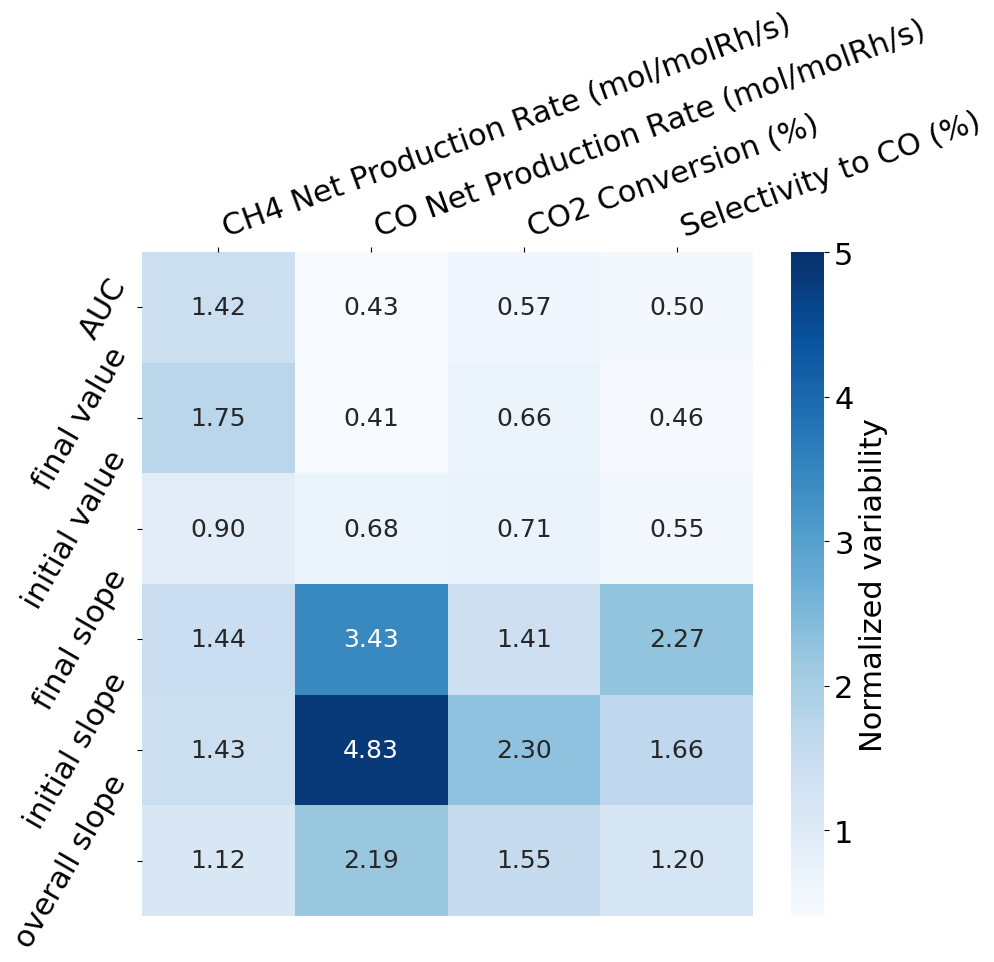

In [5]:
plot_variability(exclude_keywords_overall, 'overall', average_same_location=False)

### (b) A heatmap for interlab normalized variability of target metrics.

32 excel files were found:
0 files were filtered out:
data indexed 0 is not nominal:  0.020099999999999996 -> 0.02
data indexed 1 is not nominal:  0.0204 -> 0.02
data indexed 4 is not nominal:  0.027000000000000003 -> 0.02
data indexed 5 is not nominal:  0.020099999999999996 -> 0.02
data indexed 9 is not nominal:  0.0199 -> 0.02
data indexed 10 is not nominal:  0.0197 -> 0.02
data indexed 11 is not nominal:  0.0204 -> 0.02
data indexed 13 is not nominal:  0.020099999999999996 -> 0.02
data indexed 14 is not nominal:  0.0207 -> 0.02
data indexed 15 is not nominal:  0.021 -> 0.02
data indexed 16 is not nominal:  0.0204 -> 0.02
data indexed 17 is not nominal:  0.020099999999999996 -> 0.02
data indexed 22 is not nominal:  0.01824 -> 0.02
data indexed 29 is not nominal:  0.0202 -> 0.02
data indexed 31 is not nominal:  0.0199 -> 0.02
32 excel files were found:
0 files were filtered out:
data indexed 0 is not nominal:  0.020099999999999996 -> 0.02
data indexed 1 is not nominal:  0.0204 -> 0.02

,CH4 Net Production Rate (mol/molRh/s),CO Net Production Rate (mol/molRh/s),CO2 Conversion (%),Selectivity to CO (%)
AUC,1.323618,0.425280,0.541852,0.504631
final value,1.632027,0.408274,0.628210,0.463269
initial value,0.828015,0.678222,0.706085,0.551319
final slope,1.617786,3.428809,1.513457,2.556779
initial slope,1.429712,4.831563,2.301418,2.046230
overall slope,1.117825,2.189036,1.545609,1.111490


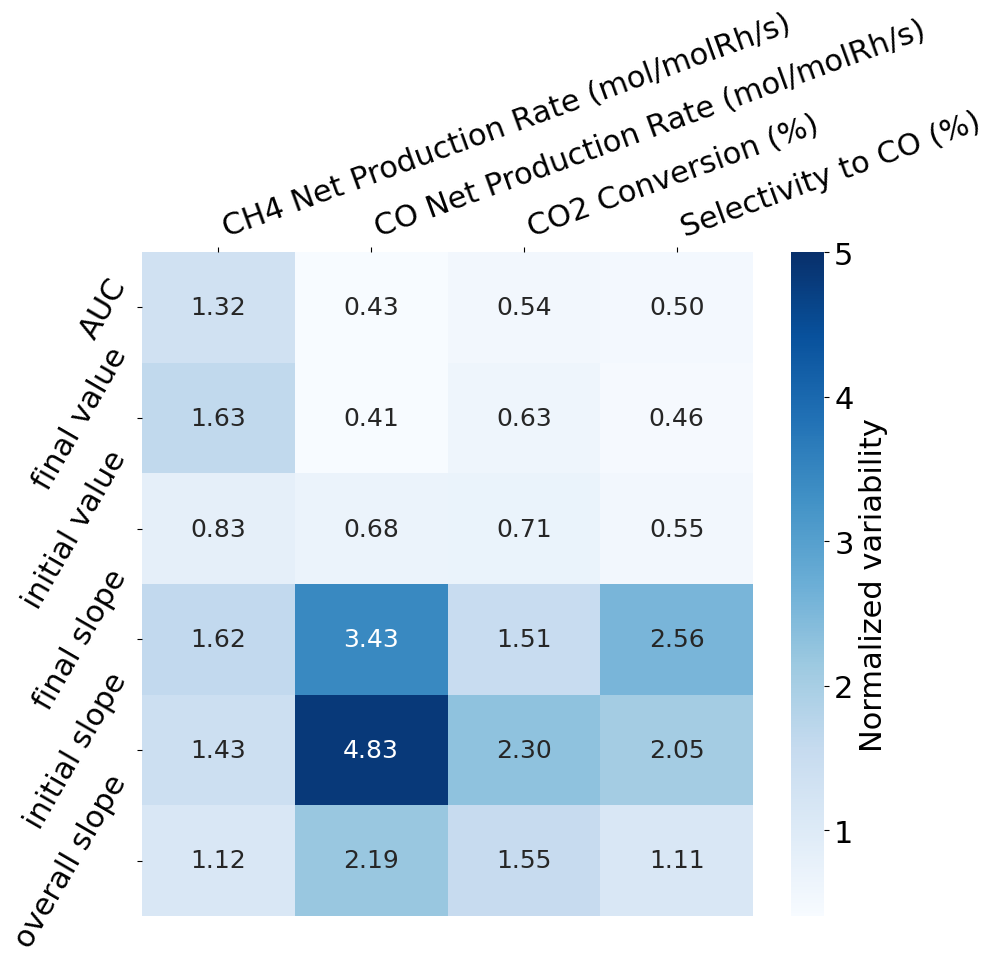

In [6]:
plot_variability(exclude_keywords_interlab, 'interlab', average_same_location=True)

### (c) A heatmap for intralab variability of target metrics, averaged over four laboratories.

* To obtain averaged intralab variability (c), the following codes need to be run first for each laboratory and then averaged.

#### 1) Intralab normalized variability heatmap for **laboratory A** (Supplementary Figure 29).

32 excel files were found:
24 files were filtered out:
../dataset/refined/alldata/0p3_RhNP_0p0201mg_500C_20250312_LaboratoryC_RR.xlsx
../dataset/refined/alldata/2_RhWI_0p0204mg_400C_20250324_LaboratoryD_.xlsx
../dataset/refined/alldata/2_RhWI_0p02mg_400C_20250306_LaboratoryC_RR.xlsx
../dataset/refined/alldata/0p3_RhNP_0p0201mg_500C_20250424_LaboratoryB_.xlsx
../dataset/refined/alldata/2_RhWI_0p02mg_600C_20250326_LaboratoryD_.xlsx
../dataset/refined/alldata/0p1_RhWI_0p02mg_500C_20250314_LaboratoryD_.xlsx
../dataset/refined/alldata/2_RhWI_0p02mg_600C_20250423_LaboratoryB_.xlsx
../dataset/refined/alldata/0p3_RhNP_0p0199mg_500C_20250212_LaboratoryD_.xlsx
../dataset/refined/alldata/0p3_RhNP_0p0197mg_500C_20250211_LaboratoryD_.xlsx
../dataset/refined/alldata/0p3_RhWI_0p0204mg_500C_20250421_LaboratoryB_.xlsx
../dataset/refined/alldata/0p3_RhWI_0p02mg_500C_20250331_LaboratoryB_.xlsx
../dataset/refined/alldata/0p3_RhWI_0p0201mg_500C_20250311_LaboratoryC_RR.xlsx
../dataset/refined/alldata/0p3_Rh

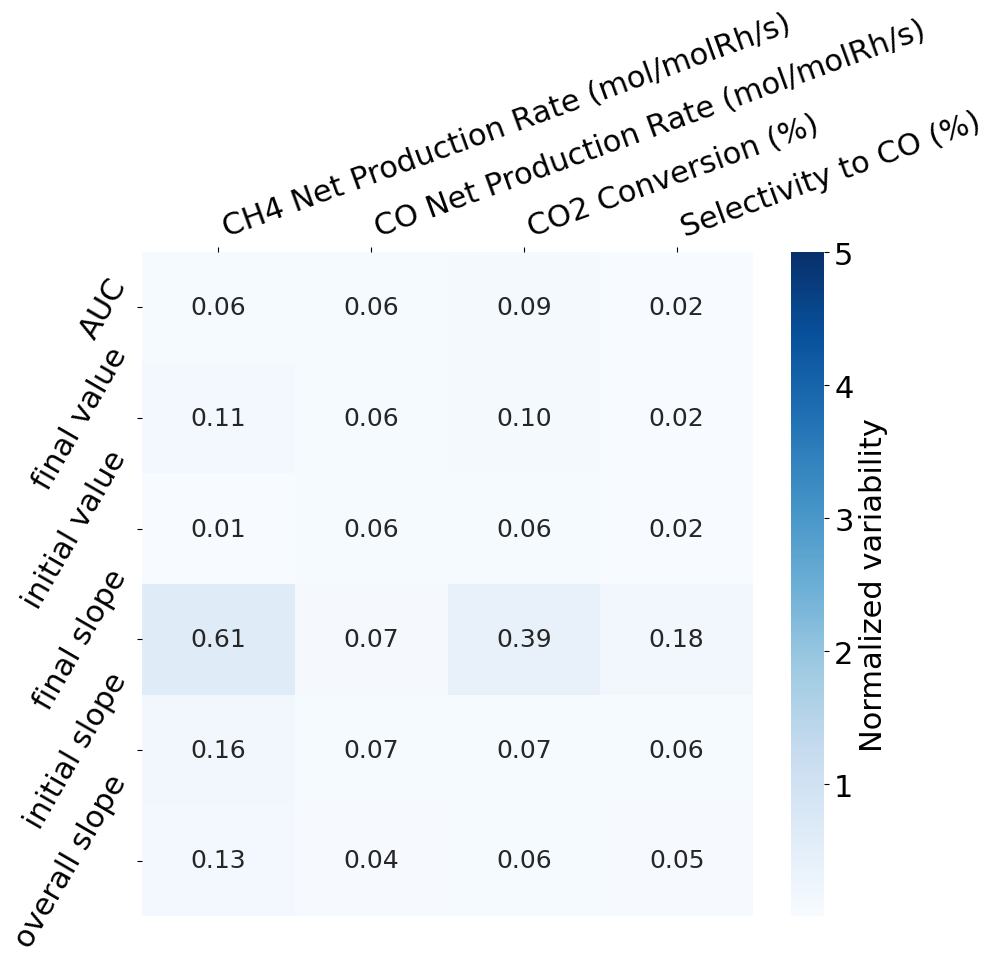

In [7]:
df_heatmap_labA = plot_variability(exclude_keywords_labA, 'labA', average_same_location=False)

#### 2) Intralab normalized variability heatmap for **laboratory B** (Supplementary Figure 29).

32 excel files were found:
24 files were filtered out:
../dataset/refined/alldata/0p3_RhNP_0p0201mg_500C_20250312_LaboratoryC_RR.xlsx
../dataset/refined/alldata/2_RhWI_0p0204mg_400C_20250324_LaboratoryD_.xlsx
../dataset/refined/alldata/2_RhWI_0p02mg_400C_20250306_LaboratoryC_RR.xlsx
../dataset/refined/alldata/0p1_RhWI_0p02_500C_20250414_LaboratoryA_Right.xlsx
../dataset/refined/alldata/2_RhWI_0p027_600C_20250422_LaboratoryA_Right.xlsx
../dataset/refined/alldata/2_RhWI_0p02mg_600C_20250326_LaboratoryD_.xlsx
../dataset/refined/alldata/0p1_RhWI_0p02mg_500C_20250314_LaboratoryD_.xlsx
../dataset/refined/alldata/0p3_RhNP_0p0199mg_500C_20250212_LaboratoryD_.xlsx
../dataset/refined/alldata/0p3_RhNP_0p0197mg_500C_20250211_LaboratoryD_.xlsx
../dataset/refined/alldata/0p3_RhWI_0p0201mg_500C_20250311_LaboratoryC_RR.xlsx
../dataset/refined/alldata/0p3_RhWI_0p0207_500C_20250315_LaboratoryA_Right.xlsx
../dataset/refined/alldata/2_RhWI_0p021_400C_20250425_LaboratoryA_Right.xlsx
../dataset/refined/alld

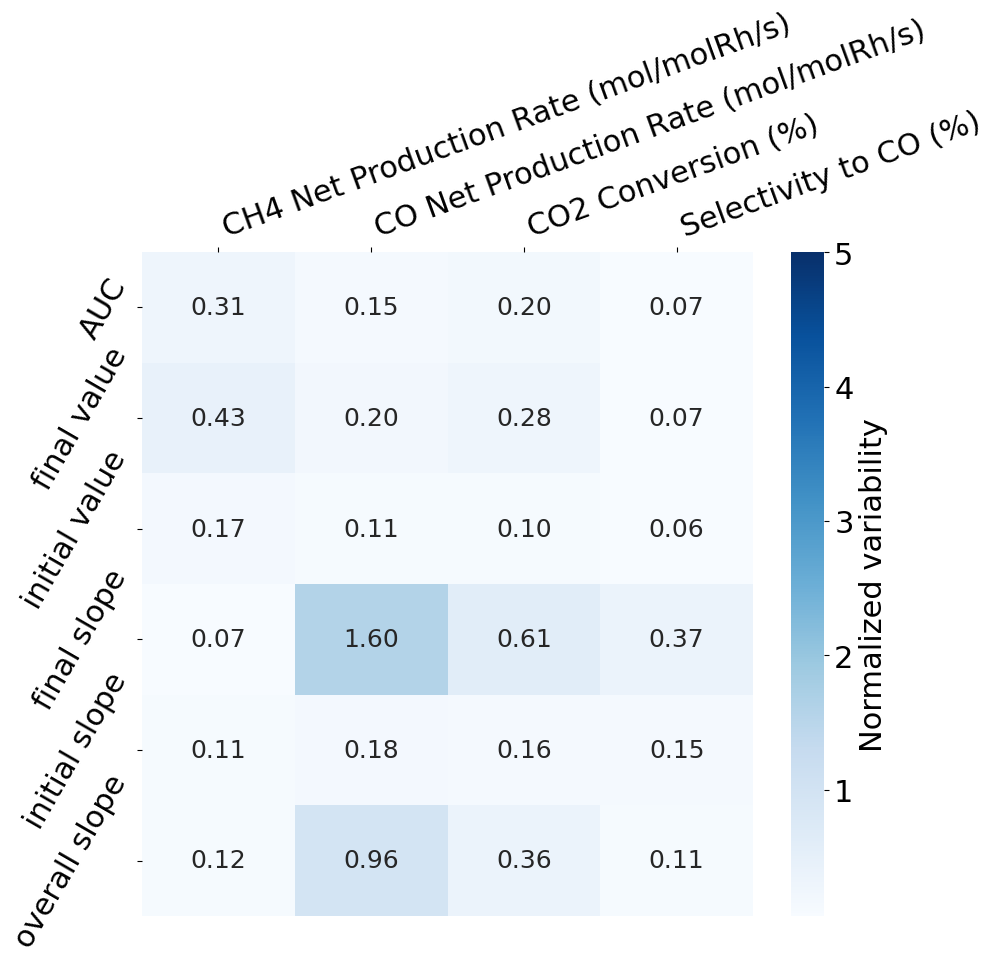

In [9]:

df_heatmap_labB = plot_variability(exclude_keywords_labB, 'labB', average_same_location=False)

#### 3) Intralab normalized variability heatmap for **laboratory C** (Supplementary Figure 29).

32 excel files were found:
24 files were filtered out:
../dataset/refined/alldata/2_RhWI_0p0204mg_400C_20250324_LaboratoryD_.xlsx
../dataset/refined/alldata/0p1_RhWI_0p02_500C_20250414_LaboratoryA_Right.xlsx
../dataset/refined/alldata/2_RhWI_0p027_600C_20250422_LaboratoryA_Right.xlsx
../dataset/refined/alldata/0p3_RhNP_0p0201mg_500C_20250424_LaboratoryB_.xlsx
../dataset/refined/alldata/2_RhWI_0p02mg_600C_20250326_LaboratoryD_.xlsx
../dataset/refined/alldata/0p1_RhWI_0p02mg_500C_20250314_LaboratoryD_.xlsx
../dataset/refined/alldata/2_RhWI_0p02mg_600C_20250423_LaboratoryB_.xlsx
../dataset/refined/alldata/0p3_RhNP_0p0199mg_500C_20250212_LaboratoryD_.xlsx
../dataset/refined/alldata/0p3_RhNP_0p0197mg_500C_20250211_LaboratoryD_.xlsx
../dataset/refined/alldata/0p3_RhWI_0p0204mg_500C_20250421_LaboratoryB_.xlsx
../dataset/refined/alldata/0p3_RhWI_0p02mg_500C_20250331_LaboratoryB_.xlsx
../dataset/refined/alldata/0p3_RhWI_0p0207_500C_20250315_LaboratoryA_Right.xlsx
../dataset/refined/alldata/2_Rh

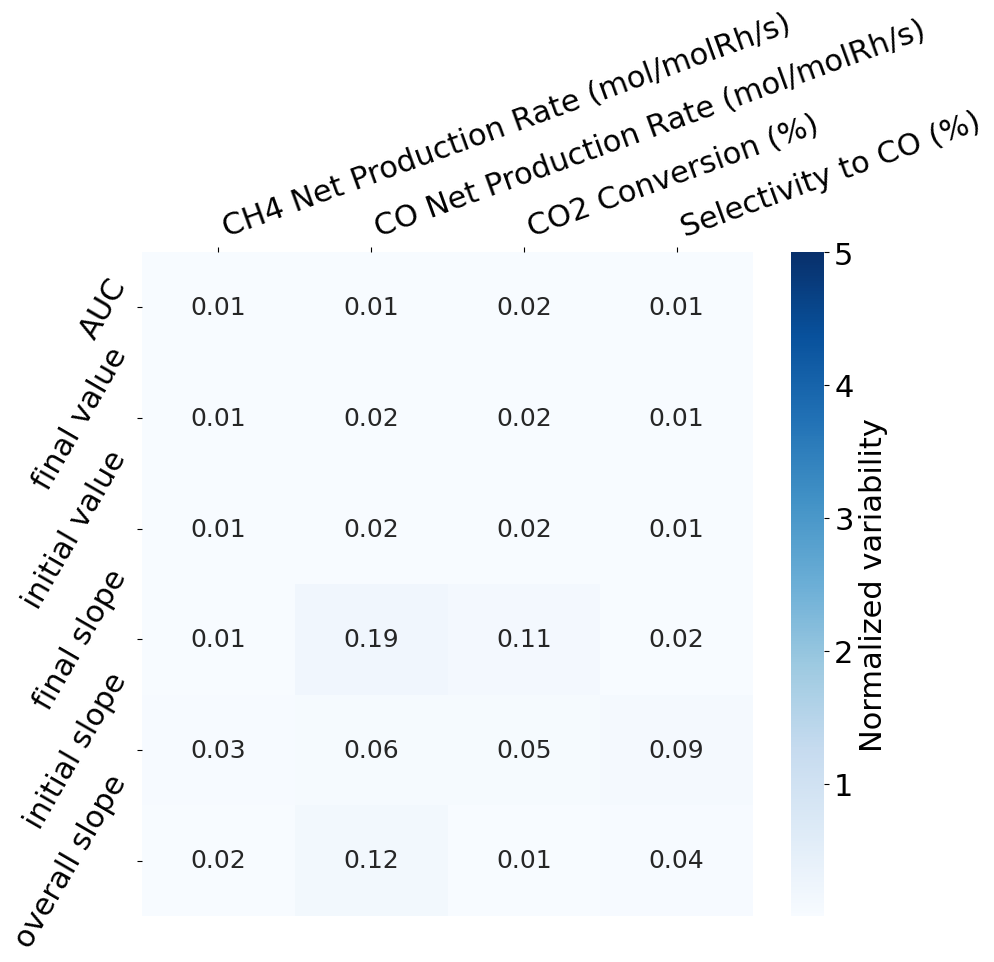

In [10]:

df_heatmap_labC = plot_variability(exclude_keywords_labC, 'labC', average_same_location=False)

#### 4) Intralab normalized variability heatmap for **laboratory D** (Supplementary Figure 29).

32 excel files were found:
24 files were filtered out:
../dataset/refined/alldata/0p3_RhNP_0p0201mg_500C_20250312_LaboratoryC_RR.xlsx
../dataset/refined/alldata/2_RhWI_0p02mg_400C_20250306_LaboratoryC_RR.xlsx
../dataset/refined/alldata/0p1_RhWI_0p02_500C_20250414_LaboratoryA_Right.xlsx
../dataset/refined/alldata/2_RhWI_0p027_600C_20250422_LaboratoryA_Right.xlsx
../dataset/refined/alldata/0p3_RhNP_0p0201mg_500C_20250424_LaboratoryB_.xlsx
../dataset/refined/alldata/2_RhWI_0p02mg_600C_20250423_LaboratoryB_.xlsx
../dataset/refined/alldata/0p3_RhWI_0p0204mg_500C_20250421_LaboratoryB_.xlsx
../dataset/refined/alldata/0p3_RhWI_0p02mg_500C_20250331_LaboratoryB_.xlsx
../dataset/refined/alldata/0p3_RhWI_0p0201mg_500C_20250311_LaboratoryC_RR.xlsx
../dataset/refined/alldata/0p3_RhWI_0p0207_500C_20250315_LaboratoryA_Right.xlsx
../dataset/refined/alldata/2_RhWI_0p021_400C_20250425_LaboratoryA_Right.xlsx
../dataset/refined/alldata/0p3_RhNP_0p0204_500C_20250315_LaboratoryA_Left.xlsx
../dataset/refined/

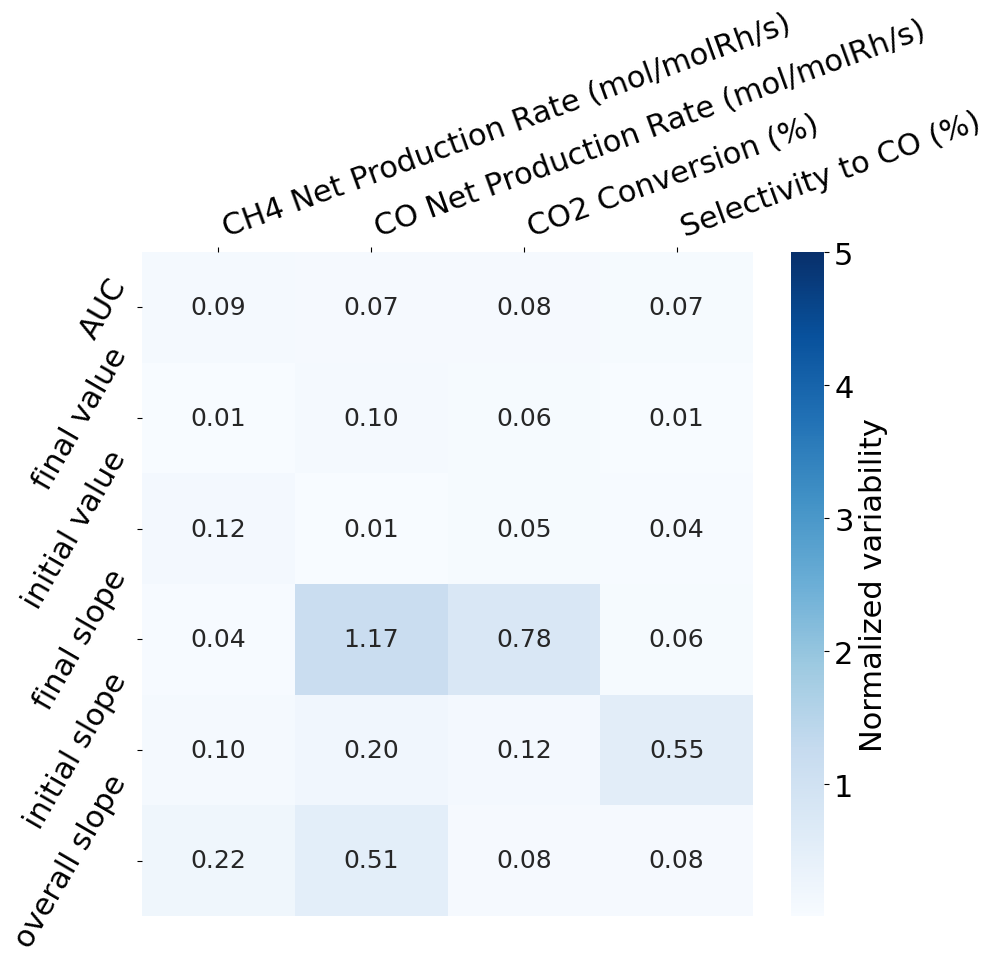

In [11]:

df_heatmap_labD = plot_variability(exclude_keywords_labD, 'labD', average_same_location=False)

Now, the four individual heatmaps are averaged (Supplementary Figure 28 (c)).

In [12]:
# average of the four heatmaps
df_heatmap_avg = (df_heatmap_labA + df_heatmap_labB + df_heatmap_labC + df_heatmap_labD) / 4.0

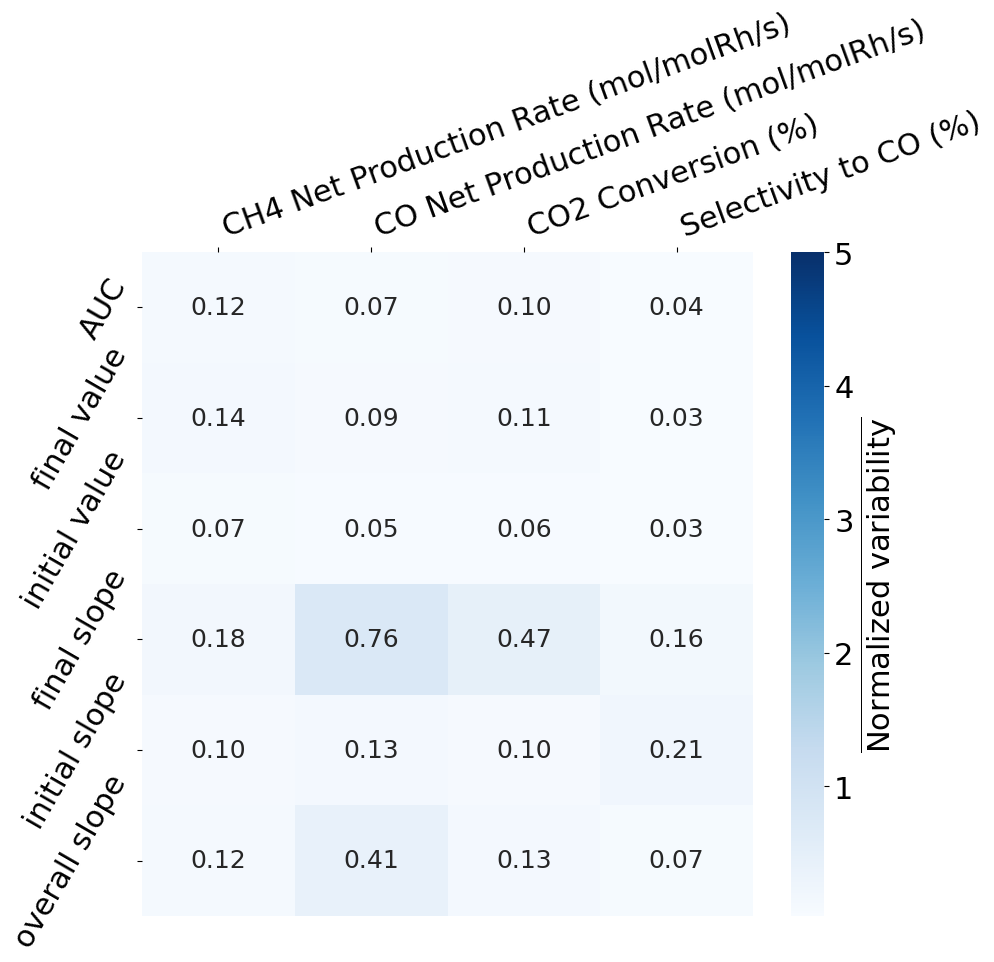

In [13]:
# Plot the average heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10.3, 10))
# Set the font sizes for the plot
label_size = 22; annot_size = 18; plt.rcParams.update({'font.size': label_size})
vmax = 5.0; vmin = None
vmax = df_heatmap_avg.max().max() if vmax is None else vmax
vmin = df_heatmap_avg.min().min() if vmin is None else vmin
which_to_plot = 'std_dev_mean_normalized'
cbar_label =  r'$\overline{\text{Normalized variability}}$'
cmap = 'Blues'

sns.heatmap(
    df_heatmap_avg,
    annot=True, fmt='.2f',
    annot_kws={'fontsize': annot_size}, # set fontsize for the annotation
    cmap=cmap,
    cbar_kws={'label': cbar_label},
    vmax=vmax, vmin=vmin,
    ax=ax, # use the ax parameter to plot the heatmap on the provided axis
)

# change the position of the xticklabels
ax.xaxis.set_ticks_position("top")
# Rotate xtick labels
plt.xticks(ha='left', fontsize=label_size, rotation=20)
plt.yticks(ha='right', fontsize=label_size, rotation=60)
plt.tight_layout()

# reset the font size
plt.rcParams.update({'font.size': 10})
plt.savefig(f'heatmap_{which_to_plot}_intra_avg.png', dpi=300, bbox_inches='tight')